In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error, explained_variance_score
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
from utils_plot import *

In [2]:
# 1. Data Normalization

def preprocessing(alpha1, alpha2, N, ampl_threshold=0):

    targetnames = np.array(list(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
     
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    N_norm = N - np.mean(N, axis=0, keepdims=True)

    return alpha1_norm, alpha2_norm, N_norm, targetnames_filtered, tf_names_filtered

In [3]:
# 2. Ridge Regression Solver

def ridge_regression_solution(alpha_norm, N_norm, lam):
    """
    Solves for A in the ridge regression model:
      (N_norm.T @ N_norm + lam I) * A = N_norm.T @ alpha_norm
    Returns A, with shape (n_motifs, n_cells).
    """
    M = N_norm.T @ N_norm  # shape: (n_motifs, n_motifs)
    I = np.eye(M.shape[0])
    A = solve(M + lam * I, N_norm.T @ alpha_norm)
    return A

In [4]:
# 3. Cross-Validation to Optimize Lambda
def lambda_optimization(alpha1_norm, alpha2_norm, N_norm, lam_candidates):
    
    EV_train = []
    EV_test = []
    MSE_train = []
    MSE_test = []
    
    for alpha_train, alpha_test in [(alpha1_norm, alpha2_norm), (alpha2_norm, alpha1_norm)]:
        
        EV_train_fold = []
        EV_test_fold = []
        MSE_train_fold = []
        MSE_test_fold = []
        
        # For each candidate lambda, compute the model predictions.
        for lam in lam_candidates:
            # Fit the ridge regression model on training set:
            A = ridge_regression_solution(alpha_train, N_norm, lam)
            # Predictions for training and test sets:
            R = N_norm @ A

            # Compute EV per gene
            EV_train_fold.append(explained_variance_score(alpha_train, R))
            EV_test_fold.append(explained_variance_score(alpha_test, R))
            
            MSE_train_fold.append(mean_squared_error(alpha_train, R))
            MSE_test_fold.append(mean_squared_error(alpha_test, R))
            
        EV_train.append(EV_train_fold)
        EV_test.append(EV_test_fold)
        MSE_train.append(MSE_train_fold)
        MSE_test.append(MSE_test_fold)
        
    EV_train = np.array(EV_train)
    EV_test = np.array(EV_test)
    MSE_train = np.array(MSE_train)
    MSE_test = np.array(MSE_test)
        
    avg_EV_test = np.mean(EV_test, axis=0)
    avg_MSE_test = np.mean(MSE_test, axis=0)
    
    # Here, we choose the lambda that gives the highest average EV (you could also choose by lowest MSE).
    best_index = np.argmax(avg_EV_test)
    best_lam = lam_candidates[best_index]
    best_EV = avg_EV_test[best_index]
    best_MSE = avg_MSE_test[best_index]
    
    # Plot the performance metrics vs lambda:
    plt.figure(figsize=(12, 5))
    
    # Subplot for Explained Variance:
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(lam_candidates, EV_train[i], linestyle="--", color="green", alpha=0.6, label="Train"+str(i+1))
        plt.plot(lam_candidates, EV_test[i], linestyle="--", color="orange", alpha=0.6, label="Test"+str(i+1))
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("EV")
    plt.title("Explained Variance vs Lambda")
    plt.legend()
    plt.grid(True)
    
    # Subplot for Mean Squared Error:
    plt.subplot(1, 2, 2)
    for i in range(2):
        plt.plot(lam_candidates, MSE_train[i], linestyle="--", color="blue", alpha=0.6, label="Train"+str(i+1))
        plt.plot(lam_candidates, MSE_test[i], linestyle="--", color="magenta", alpha=0.6, label="Test"+str(i+1))
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("MSE vs Lambda")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return best_lam, best_EV, best_MSE

In [5]:
#4. Final perf evaluation on best lambda
def train_best_model(alpha1_norm, alpha2_norm, N_norm, best_lam):
    
    for alpha_train, alpha_test in [(alpha1_norm, alpha2_norm), (alpha2_norm, alpha1_norm)]:
        
        # Fit the ridge regression model on training set:
        A = ridge_regression_solution(alpha_train, N_norm, best_lam)
        # Predictions for training and test sets:
        R = N_norm @ A
        
        print("EV_train :", round(explained_variance_score(alpha_train, R)*100,2), "%", "MSE_train :", round(mean_squared_error(alpha_train, R),2))
        print("EV_test :", round(explained_variance_score(alpha_test, R)*100,2), "%", "MSE_test :", round(mean_squared_error(alpha_test, R),3), "\n")
     
    return A, alpha2_norm, alpha1_norm, R

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360)


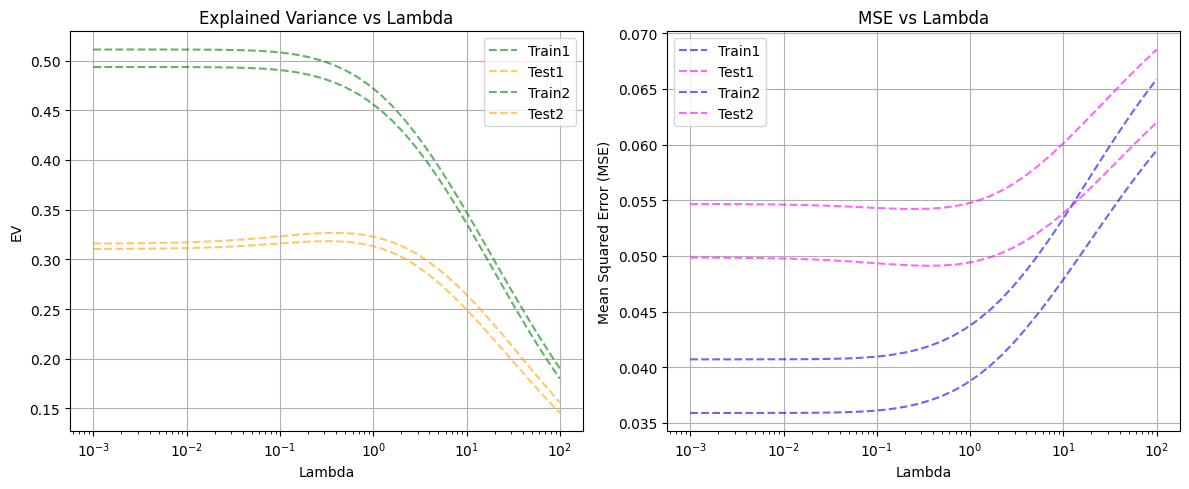

Best lambda: 0.37
Best EV : 32.25 %
Best MSE: 0.052


In [6]:
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
lam_candidates = np.logspace(-3, 2, 40)

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.2
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape)

# Define candidate lambda values (you may adjust this range as needed)
best_lam, best_EV, best_MSE = lambda_optimization(alpha1_norm, alpha2_norm, N_norm, lam_candidates)
print("Best lambda:", round(best_lam, 2))
print("Best EV :", round(best_EV*100,2), "%")
print("Best MSE:", round(best_MSE, 3))

In [7]:
A, alpha_train, alpha_test, R = train_best_model(alpha1_norm, alpha2_norm, N_norm, best_lam)

EV_train : 47.87 % MSE_train : 0.04
EV_test : 32.66 % MSE_test : 0.049 

EV_train : 49.6 % MSE_train : 0.04
EV_test : 31.83 % MSE_test : 0.054 



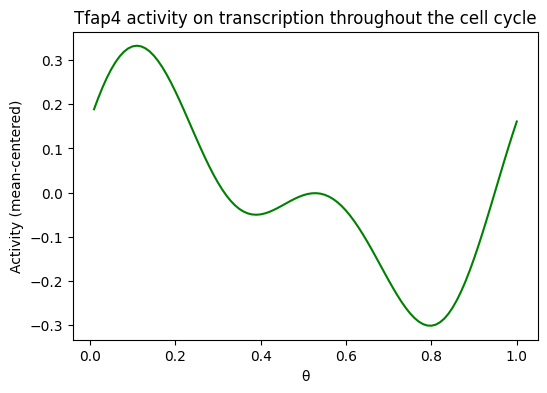

In [8]:
BP_nb = np.where(tf_names == 'Tfap4')[0][0]
plot_binding_protein_activity(tf_names, A, process, theta_smooth, BP_nb=BP_nb)

In [9]:
tf_names

Index(['Ahr', 'Aire', 'Arid3a', 'Arid5b', 'Arnt', 'Arnt2',
       'Arntl_Tfe3_Mlx_Mitf_Mlxipl_Tfec', 'Ascl2', 'Atf1_Creb5', 'Atf3',
       ...
       'Zbtb7a', 'Zbtb7b', 'Zbtb7c', 'Zfhx3', 'Zfp128', 'Zfp263', 'Zfp652',
       'Zfx_Mecp2', 'Zkscan1', 'Zkscan3'],
      dtype='object', length=360)

['Hoxb6' 'Mnx1_Lhx6_Lmx1a' 'Cbfb' 'Stat2' 'Trp53' 'Nkx2-3' 'Bcl6b' 'Batf'
 'Sox30' 'Thrb' 'Foxd3' 'Aire' 'Pou6f2_Pou4f2' 'Rxrb' 'Tcf7l1' 'Hes1'
 'Ptf1a' 'Hoxb2_Dlx2' 'Crx_Gsc' 'Nfatc4' 'Rora' 'Cxxc1' 'Zkscan3'
 'Hoxa7_Hoxc8' 'Hoxd11_Cdx1_Hoxc11']


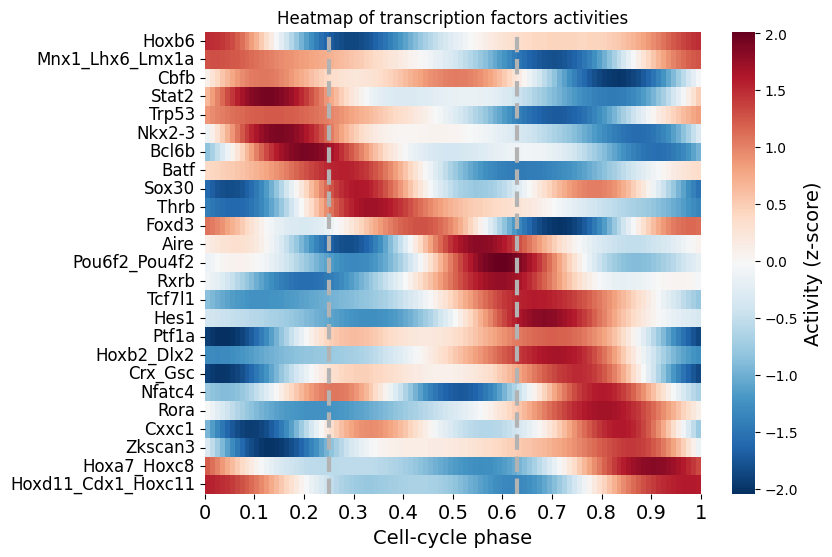

In [10]:
#Heatmap of BPs activity along cell cycle
tf_displayed = plot_heatmap(A, ylabels=tf_names, display_limit=25)
print(tf_displayed)

In [11]:
N_norm

array([[-0.23415164, -0.00484798, -0.00431941, ..., -0.92474772,
        -0.00553015, -0.00579866],
       [-0.23415164, -0.00484798, -0.00431941, ...,  0.35365228,
        -0.00553015, -0.00579866],
       [ 0.28863836, -0.00484798, -0.00431941, ..., -0.92474772,
        -0.00553015, -0.00579866],
       ...,
       [-0.23415164, -0.00484798, -0.00431941, ...,  0.54925228,
        -0.00553015, -0.00579866],
       [-0.23415164, -0.00484798, -0.00431941, ..., -0.92474772,
        -0.00553015, -0.00579866],
       [ 0.35281836, -0.00484798, -0.00431941, ...,  0.77664228,
        -0.00553015, -0.00579866]])

Train


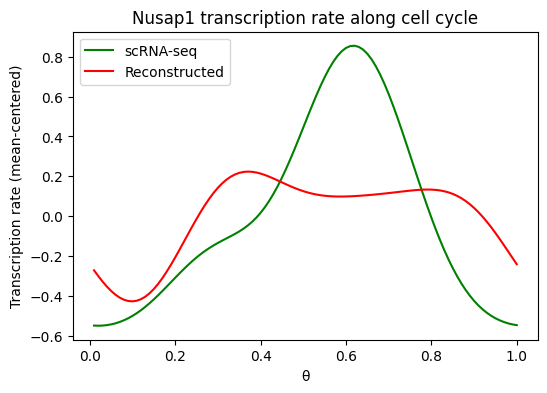

Test


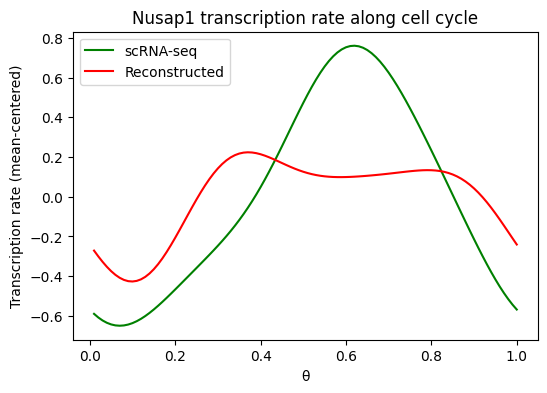

In [12]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 8
print("Train")
plot_rate_comparison(targetnames, alpha_train, R, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, alpha_test, R, process, theta_smooth, target_nb=n)

In [13]:
#### APPENDIX

In [14]:
# Calculate z-values error bars for activities

def compute_covariance_matrix(N_norm, lam):
    """
    Computes the inverse term common to all cells: inv(N_norm.T @ N_norm + lam I).
    This will later be scaled by sigma^2 per cell.
    """
    M = N_norm.T @ N_norm
    I = np.eye(M.shape[0])
    inv_term = inv(M + lam * I)
    return inv_term

def compute_residual_variance(alpha_norm, N_norm, A):
    """
    Computes the residual variance (sigma^2) per cell.
    For each cell (each column in alpha_norm), calculate the mean squared error
    between the observed alpha_norm and the predicted values from N_norm @ A.
    """
    residuals = alpha_norm - (N_norm @ A)
    sigma2 = np.mean(residuals**2, axis=0)  # one value per cell
    return sigma2

def get_z_values(alpha_norm, N_norm, A, best_lam):
    # Compute residual variance per cell
    sigma2 = compute_residual_variance(alpha_norm, N_norm, A)
    
    # Compute the inverse term (common for all cells) for covariance estimation
    inv_term = compute_covariance_matrix(N_norm, best_lam)
    
    # For each cell, compute the standard errors for each motif activity.
    n_motifs, n_cells = A.shape
    error_bars = np.zeros((n_motifs, n_cells))
    for j in range(n_cells):
        # Standard error for each motif m in cell j: sqrt(diag(inv_term) * sigma2[j])
        error_bars[:, j] = np.sqrt(np.diag(inv_term) * sigma2[j])
    
    # Compute z-values for each motif and cell
    z_values = A / error_bars
    return z_values

#z_values = get_z_values(alpha_norm, N_norm, A, best_lam)